<a href="https://colab.research.google.com/github/atul1234anand/fastai/blob/master/2way.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from fastai.text import *

In [3]:
!git clone https://github.com/Tariq60/LIAR-PLUS.git

Cloning into 'LIAR-PLUS'...
remote: Enumerating objects: 9, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 77 (delta 2), reused 0 (delta 0), pack-reused 68
Unpacking objects: 100% (77/77), done.


In [0]:
path = Path('/content/LIAR-PLUS/dataset')

In [5]:
path.ls()

[PosixPath('/content/LIAR-PLUS/dataset/val2.tsv'),
 PosixPath('/content/LIAR-PLUS/dataset/train2.tsv'),
 PosixPath('/content/LIAR-PLUS/dataset/test2.tsv')]

In [0]:
#data_F = pd.read_csv('/content/LIAR-PLUS/dataset/train2.tsv',delimiter='\t',encoding='utf-8', error_bad_lines=False,usecols=[2,3],names=['label','text'])
#data_F = pd.read_csv('/content/LIAR-PLUS/dataset/test2.tsv',delimiter='\t',encoding='utf-8', error_bad_lines=False,usecols=[2,3],names=['label','text'])
data_F = pd.read_csv('/content/LIAR-PLUS/dataset/val2.tsv',delimiter='\t',encoding='utf-8', error_bad_lines=False,usecols=[2,3],names=['label','text'])

In [16]:
data_F.head()

,label,text
0,barely-true,We have less Americans working now than in the...
1,pants-fire,"When Obama was sworn into office, he DID NOT u..."
2,false,Says Having organizations parading as being so...
3,half-true,Says nearly half of Oregons children are poor.
4,half-true,On attacks by Republicans that various program...


In [0]:
#df.replace(to_replace =["Boston Celtics", "Texas"],  value ="Omega Warrior") 
data_F = data_F.replace(to_replace =['pants-fire','mostly-false','false'],  value ="false")
data_F = data_F.replace(to_replace =['half-true','mostly-true','true','barely-true'],  value ="true")

In [18]:
data_F.head()

,label,text
0,true,We have less Americans working now than in the...
1,false,"When Obama was sworn into office, he DID NOT u..."
2,false,Says Having organizations parading as being so...
3,true,Says nearly half of Oregons children are poor.
4,true,On attacks by Republicans that various program...


In [0]:
#data_F.to_csv('/content/LIAR-PLUS/dataset/train.csv') 
#data_F.to_csv('/content/LIAR-PLUS/dataset/test.csv') 
data_F.to_csv('/content/LIAR-PLUS/dataset/val.csv') 

In [0]:
data_lm = TextLMDataBunch.from_csv(path,'train.csv')

In [0]:
data_lm.save('data_lm.pkl')

In [0]:
bs = 10
data_lm = load_data(path, 'data_lm.pkl', bs=bs)

In [0]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.5)

In [24]:

learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


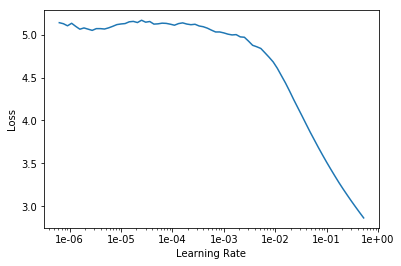

In [25]:
learn.recorder.plot(skip_end=15)

In [26]:
learn.fit_one_cycle(1, slice(1e-3,1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,1.481433,0.240545,0.906508,00:02


In [0]:
learn.unfreeze()

In [28]:
learn.fit_one_cycle(10, slice(1e-3,1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.270645,0.204096,0.906508,00:03
1,0.233864,0.201292,0.906032,00:03
2,0.217218,0.203395,0.906508,00:03
3,0.208958,0.201641,0.906508,00:03
4,0.218443,0.217191,0.906032,00:03
5,0.209202,0.203756,0.906032,00:03
6,0.208824,0.211493,0.906032,00:03
7,0.204032,0.201039,0.906032,00:03
8,0.201969,0.201256,0.906032,00:03
9,0.200947,0.201200,0.906032,00:03


In [0]:
learn.save_encoder('fine_tuned_enc')

In [0]:
data_class = TextDataBunch.from_csv(path, 'train.csv',vocab = data_lm.vocab,test = 'test.csv',text_cols = 'text',label_cols = 'label')

In [31]:
data_class.show_batch()

text,target
xxbos xxmaj xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxmaj xxunk xxunk xxunk xxmaj xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxmaj xxunk xxmaj xxunk xxmaj xxunk xxunk xxunk,True
xxbos xxmaj xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxmaj xxunk xxunk xxmaj xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxup xxunk xxunk xxmaj xxunk xxmaj xxunk xxunk xxunk xxunk true xxunk xxmaj xxunk xxmaj xxunk xxunk xxunk xxmaj,False
xxbos xxmaj xxunk xxmaj xxunk xxunk xxunk xxunk xxunk xxmaj xxunk xxunk xxmaj xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxmaj xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxmaj xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxmaj xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxmaj xxunk xxunk xxunk xxunk xxunk xxmaj xxunk xxunk xxmaj xxunk,True
xxbos xxmaj xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxmaj xxunk xxunk xxmaj xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxmaj,False
xxbos xxmaj xxunk xxmaj xxunk xxmaj xxunk xxunk xxunk xxmaj xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxmaj xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxmaj xxunk xxunk xxunk xxunk xxunk xxunk xxmaj xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk,True


In [0]:
data_class.save('data_class.pkl')
data_clas = load_data(path, 'data_class.pkl', bs=bs)

In [0]:
learner = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)
learner.load_encoder('fine_tuned_enc')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


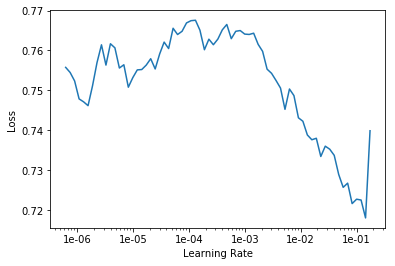

In [34]:
learner.lr_find()
learner.recorder.plot(skip_end=15)

In [35]:
learner.fit_one_cycle(2, 1e-3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.565310,0.607704,0.725720,00:18
1,0.588978,0.587583,0.725720,00:19


In [0]:
learner.save('first')
learner.load('first')

In [37]:
learner.freeze_to(-2)
learner.fit_one_cycle(2,1e-3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.598166,0.587162,0.725720,00:21
1,0.571978,0.586266,0.725720,00:20


In [0]:
learn.save('second')
learn.load('second')

In [39]:
learner.freeze_to(-3)
learner.fit_one_cycle(1, slice(1e-4,1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.582132,0.585760,0.725720,00:30


In [40]:
learner.unfreeze()
learner.fit_one_cycle(5, 1e-3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.600345,0.586815,0.725720,00:39
1,0.596291,0.588545,0.725720,00:36
2,0.600748,0.587011,0.725720,00:38
3,0.591412,0.585591,0.725720,00:37
4,0.611954,0.584296,0.725720,00:37


In [0]:
data_val = TextDataBunch.from_csv(path, 'train.csv',vocab = data_lm.vocab,test = 'val.csv',text_cols = 'text',label_cols = 'label')

In [42]:
data_class.show_batch()

text,target
xxbos xxmaj xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxmaj xxunk xxunk xxunk xxmaj xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxmaj xxunk xxmaj xxunk xxmaj xxunk xxunk xxunk,True
xxbos xxmaj xxunk xxmaj xxunk xxunk xxunk xxunk xxunk xxmaj xxunk xxunk xxmaj xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxmaj xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxmaj xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxmaj xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxmaj xxunk xxunk xxunk xxunk xxunk xxmaj xxunk xxunk xxmaj xxunk,True
xxbos xxmaj xxunk xxmaj xxunk xxmaj xxunk xxunk xxunk xxmaj xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxmaj xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxmaj xxunk xxunk xxunk xxunk xxunk xxunk xxmaj xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk,True
xxbos xxmaj xxunk xxmaj xxunk xxmaj xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxmaj xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk,True
xxbos xxmaj xxunk xxmaj xxunk xxunk xxunk xxunk xxunk xxunk xxmaj xxunk xxunk xxmaj xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxmaj xxunk xxunk xxunk xxunk xxunk xxunk xxmaj xxunk xxunk xxunk xxunk xxunk xxunk xxmaj xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxmaj xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxmaj xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxmaj xxunk xxunk xxunk xxunk xxunk,True


In [0]:
data_val.save('data_val.pkl')
data_val = load_data(path, 'data_val.pkl', bs=bs)

In [0]:
learner1 = text_classifier_learner(data_val, AWD_LSTM, drop_mult=0.5)
learner1.load_encoder('fine_tuned_enc')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


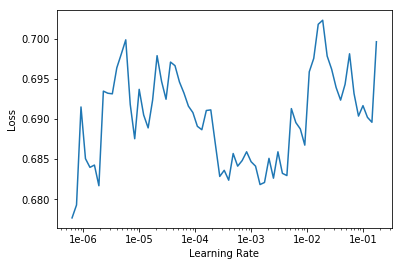

In [49]:
learner1.lr_find()
learner1.recorder.plot(skip_end=15)

In [50]:
learner1.fit_one_cycle(2, 2*1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.584988,0.610784,0.714983,00:19
1,0.583041,0.597101,0.714983,00:20


In [0]:
learner1.save('first')
learner1.load('first')

In [52]:
learner1.freeze_to(-2)
learner1.fit_one_cycle(1, 2*1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.596648,0.598583,0.714983,00:21


In [0]:
learner1.save('second')
learner1.load('second')

In [55]:
learner1.freeze_to(-3)
learner1.fit_one_cycle(1,2*1e-2,moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.602961,0.597791,0.714983,00:30


In [0]:
learner1.save('third')
learner1.load('third')

In [57]:
learner1.unfreeze()
learner1.fit_one_cycle(5,2*1e-2,moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.583746,0.598666,0.714983,00:40
1,0.581962,0.606231,0.714983,00:39
2,0.600969,0.598104,0.714983,00:39
3,0.593497,0.601185,0.714983,00:39
4,0.595306,0.599790,0.714983,00:39
